<a href="https://colab.research.google.com/github/RFJC21/titanic_classification/blob/master/titanic_ann_svm_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import datetime, os
import tensorflow as tf
%load_ext tensorboard

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Get Data

In [0]:
from google.colab import files
uploaded = files.upload()

Saving titanic_train.csv to titanic_train (2).csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['titanic_train.csv']))
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploratory Analysis

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000


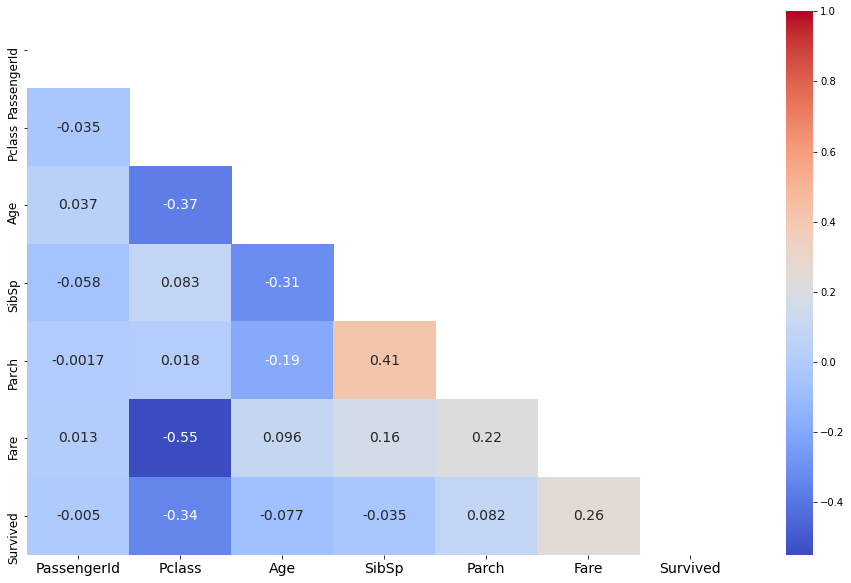

In [0]:
mask=np.zeros_like(df.corr())
triangle_indices=np.triu_indices_from(mask)
mask[triangle_indices]=True
mask

plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), mask=mask, cmap="coolwarm",annot=True, annot_kws={'size':14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

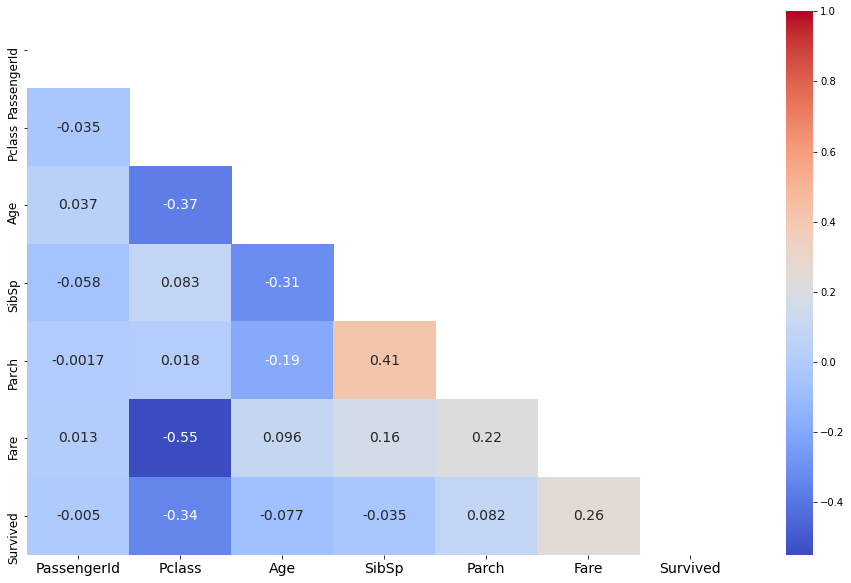

In [0]:
#Heat Map com matplotlib and seaborn
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), mask=mask, cmap="coolwarm",annot=True, annot_kws={'size':14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

In [0]:
df=df.drop('PassengerId',axis=1)

In [0]:
df=df.drop('Name',axis=1)

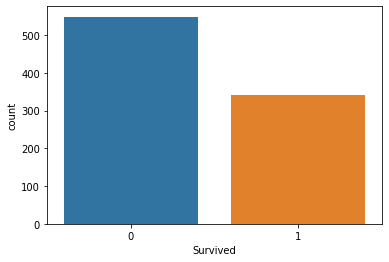

In [0]:
sns.countplot(x='Survived',data=df)

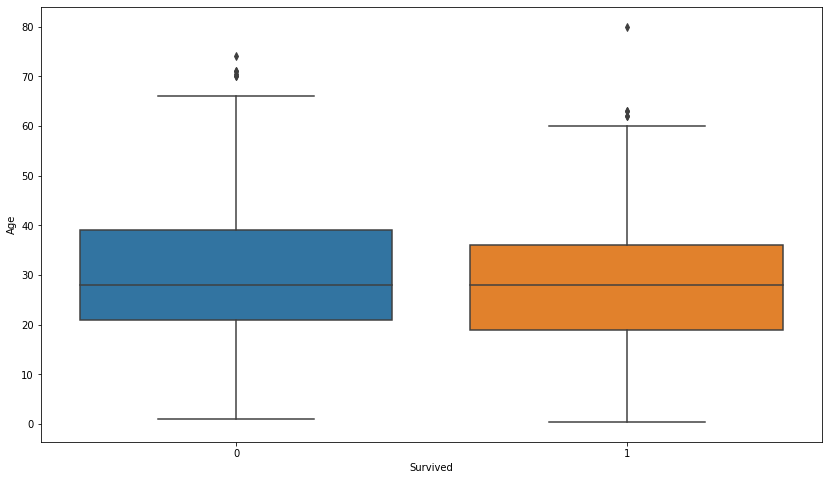

In [0]:
plt.figure(figsize=(14,8))
sns.boxplot(x='Survived',y='Age',data=df)

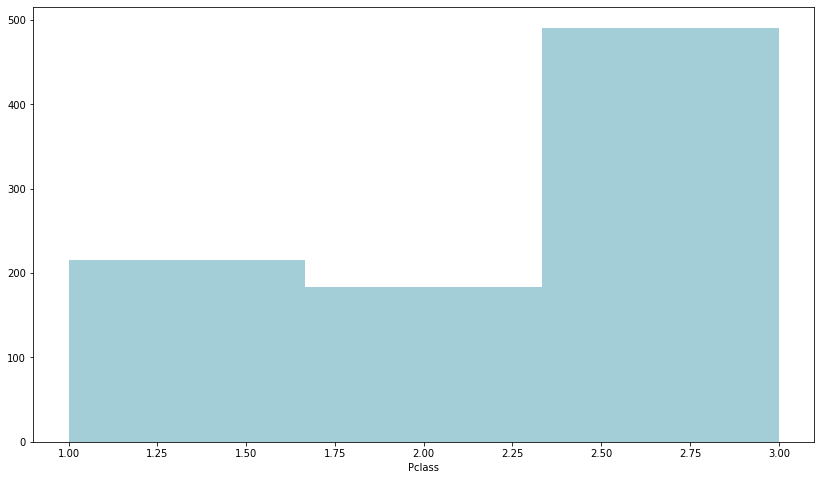

In [0]:
plt.figure(figsize=(14,8))
sns.distplot(df['Pclass'],bins=3, kde=False,color='#1c869c')

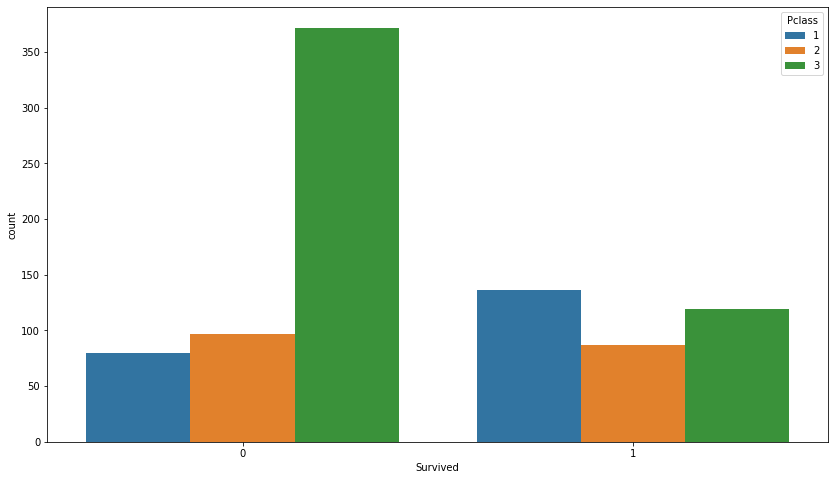

In [0]:
plt.figure(figsize=(14,8))
sns.countplot(x='Survived',hue='Pclass',data=df)

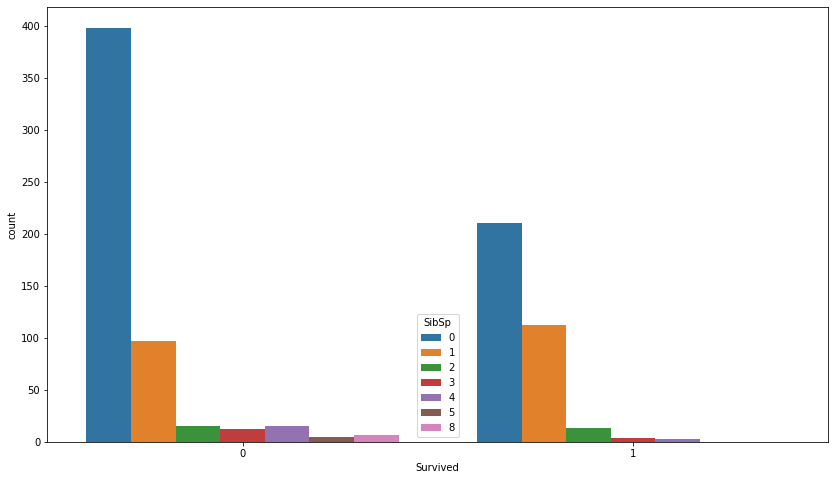

In [0]:
plt.figure(figsize=(14,8))
sns.countplot(x='Survived',hue='SibSp',data=df)

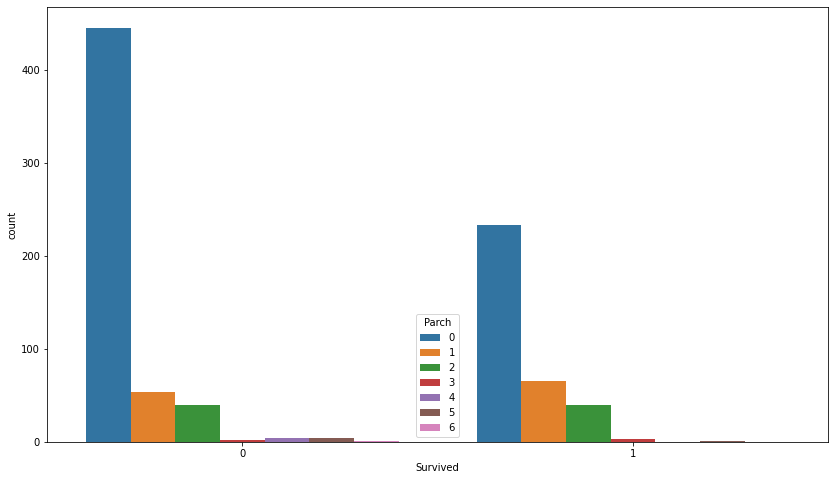

In [0]:
plt.figure(figsize=(14,8))
sns.countplot(x='Survived',hue='Parch',data=df)

In [0]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,1,female,35.0,1,0,113803,53.1000,C123,S,1
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0


In [0]:
df=df.drop('Ticket',axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [0]:
df['Age']=df['Age'].fillna(df['Age'].mean())

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [0]:
df['Cabin'].value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
F2             3
C22 C26        3
              ..
E58            1
D7             1
D30            1
B79            1
E40            1
Name: Cabin, Length: 147, dtype: int64

In [0]:
df['Cabin'] = df['Cabin'].str[:1]
df['Cabin'].value_counts()

C    35
B    18
D    13
E     9
F     8
A     7
T     1
G     1
Name: Cabin, dtype: int64

In [0]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,NaN,S,0
1,1,female,38.0,1,0,71.2833,C,C,1
2,3,female,26.0,0,0,7.9250,NaN,S,1
3,1,female,35.0,1,0,53.1000,C,S,1
4,3,male,35.0,0,0,8.0500,NaN,S,0


#Hot Encoding or dummy variables

In [0]:
df['Sex']=df['Sex'].map({'male':0,'female':1})
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,0,34.5,0,0,7.8292,NaN,Q
1,3,1,47.0,1,0,7.0000,NaN,S
2,2,0,62.0,0,0,9.6875,NaN,Q
3,3,0,27.0,0,0,8.6625,NaN,S
4,3,1,22.0,1,1,12.2875,NaN,S


In [0]:
cabin_dummies= pd.get_dummies(df['Cabin'],drop_first=True)

In [0]:
df=pd.concat([df.drop('Cabin',axis=1),cabin_dummies],axis=1)
df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'B', 'C',
       'D', 'E', 'F', 'G', 'T'],
      dtype='object')

In [0]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,B,C,D,E,F,G,T
0,3,0,22.0,1,0,7.2500,S,0,0,0,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,C,1,0,1,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,S,1,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,S,1,0,1,0,0,0,0,0
4,3,0,35.0,0,0,8.0500,S,0,0,0,0,0,0,0,0


In [0]:
df=df.drop('Embarked',axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,B,C,D,E,F,G,T
0,3,0,34.5,0,0,7.8292,0,0,0,0,0,0,0
1,3,1,47.0,1,0,7.0000,0,0,0,0,0,0,0
2,2,0,62.0,0,0,9.6875,0,0,0,0,0,0,0
3,3,0,27.0,0,0,8.6625,0,0,0,0,0,0,0
4,3,1,22.0,1,1,12.2875,0,0,0,0,0,0,0


In [0]:
X_train.shape

(757, 13)

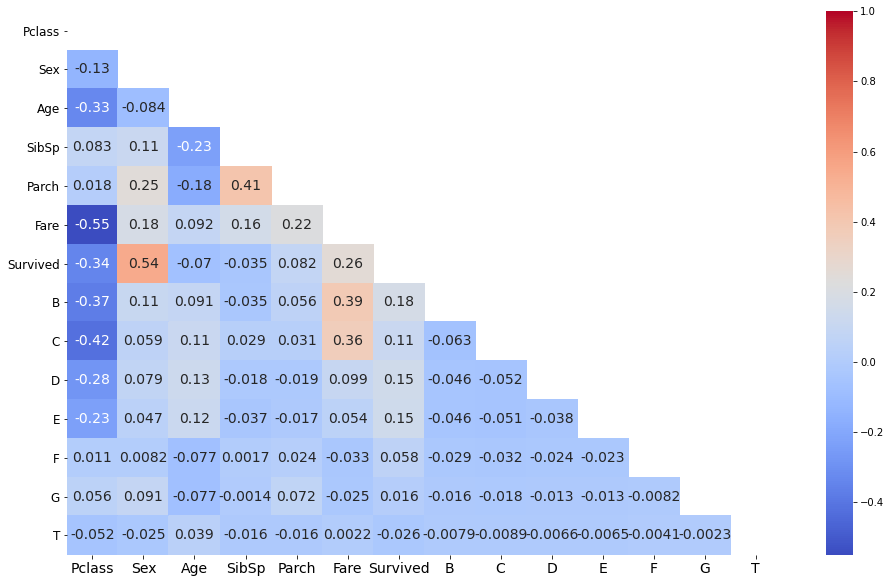

In [0]:
mask=np.zeros_like(df.corr())
triangle_indices=np.triu_indices_from(mask)
mask[triangle_indices]=True
mask

plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), mask=mask, cmap="coolwarm",annot=True, annot_kws={'size':14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.show()

In [0]:
df1=df

# Split Data

In [0]:
X=df.drop('Survived',axis=1).values
y=df['Survived'].values

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=0)

# Scale Data

In [0]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [0]:
y_test

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0])

# Create Model

In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,write_graph=True,write_images=True,profile_batch=2, embeddings_freq=1)

In [0]:
#def create_network(optimizer='adam'):

model = Sequential()

# input layer
model.add(Dense(13,  activation='relu',input_shape=[13,]))
#model.add(Dropout(0.2))

# hidden layer
model.add(Dense(7, activation='relu'))
#model.add(Dropout(0.2))

# hidden layer
model.add(Dense(7, activation='relu'))
#model.add(Dropout(0.2))

# hidden layer
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#return network

In [0]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=150)

In [0]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=500,
          validation_data=(X_test, y_test), 
         callbacks=[early_stop,tensorboard_callback])

Epoch 1/500
24/24 [==============================] - 1s 22ms/step - loss: 0.6787 - accuracy: 0.7239 - val_loss: 0.6629 - val_accuracy: 0.7463
Epoch 2/500
24/24 [==============================] - 0s 4ms/step - loss: 0.6582 - accuracy: 0.7186 - val_loss: 0.6354 - val_accuracy: 0.7388
Epoch 3/500
24/24 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.7094 - val_loss: 0.6004 - val_accuracy: 0.7463
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 0.5971 - accuracy: 0.7503 - val_loss: 0.5630 - val_accuracy: 0.7910
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 0.5602 - accuracy: 0.7688 - val_loss: 0.5238 - val_accuracy: 0.7910
Epoch 6/500
24/24 [==============================] - 0s 4ms/step - loss: 0.5191 - accuracy: 0.7807 - val_loss: 0.4918 - val_accuracy: 0.7985
Epoch 7/500
24/24 [==============================] - 0s 5ms/step - loss: 0.4891 - accuracy: 0.7794 - val_loss: 0.4711 - val_accuracy: 0.7761
Epoch 8/500


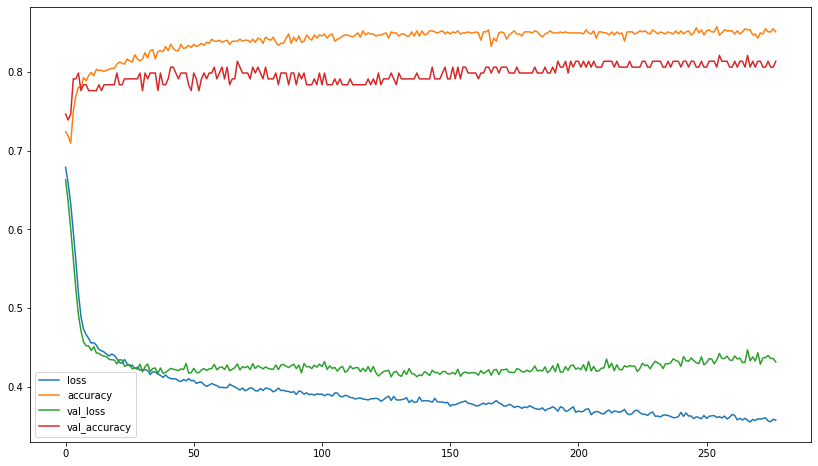

In [0]:
loss_df=pd.DataFrame(model.history.history)
loss_df.plot(figsize=(14,8))

In [0]:
loss_df

,loss,accuracy,val_loss,val_accuracy
0,0.678736,0.723910,0.662867,0.746269
1,0.658152,0.718626,0.635419,0.738806
2,0.632299,0.709379,0.600366,0.746269
3,0.597082,0.750330,0.563042,0.791045
4,0.560202,0.768824,0.523824,0.791045
...,...,...,...,...
273,0.360458,0.854690,0.437138,0.805970
274,0.356643,0.850727,0.439729,0.813433
275,0.355617,0.850727,0.435835,0.805970
276,0.358722,0.854690,0.435986,0.805970


In [0]:
predictions=model.predict_classes(X_test)

In [0]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        79
           1       0.86      0.65      0.74        55

    accuracy                           0.81       134
   macro avg       0.83      0.79      0.80       134
weighted avg       0.82      0.81      0.81       134



In [0]:
print(confusion_matrix(y_test,predictions))

[[73  6]
 [19 36]]


# Predictions

In [0]:
single_person=df.drop('Survived',axis=1).iloc[0]

In [0]:
single_person=scaler.transform(single_person.values.reshape(-1,13))

In [0]:
model.predict_classes(single_person)

array([[0]], dtype=int32)

In [0]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,B,C,D,E,F,G,T
0,3,0,22.0,1,0,7.2500,0,0,0,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,1,0,0,0,0,0,0,0
3,1,1,35.0,1,0,53.1000,1,0,1,0,0,0,0,0
4,3,0,35.0,0,0,8.0500,0,0,0,0,0,0,0,0


# SVM

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [0]:
df1

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,B,C,D,E,F,G,T
0,3,0,22.000000,1,0,7.2500,0,0,0,0,0,0,0,0
1,1,1,38.000000,1,0,71.2833,1,0,1,0,0,0,0,0
2,3,1,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0
3,1,1,35.000000,1,0,53.1000,1,0,1,0,0,0,0,0
4,3,0,35.000000,0,0,8.0500,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.000000,0,0,13.0000,0,0,0,0,0,0,0,0
887,1,1,19.000000,0,0,30.0000,1,1,0,0,0,0,0,0
888,3,1,29.699118,1,2,23.4500,0,0,0,0,0,0,0,0
889,1,0,26.000000,0,0,30.0000,1,0,1,0,0,0,0,0


In [0]:
X=df.drop('Survived',axis=1).values
y=df['Survived'].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [0]:
classifier = SVC(C= 10,gamma= 0.1,kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
y_pred_svm = classifier.predict(X_test)

In [0]:
score=accuracy_score(y_test,y_pred_svm)*100
score

79.1044776119403

In [0]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        79
           1       0.81      0.64      0.71        55

    accuracy                           0.79       134
   macro avg       0.80      0.77      0.77       134
weighted avg       0.79      0.79      0.79       134



In [0]:
print(confusion_matrix(y_test,y_pred_svm))

[[71  8]
 [20 35]]


In [0]:
# Accucary ANN = 79%
# Accuracy SVM = 79%

# Cross Validation and Grid Search



In [0]:
accuracies_DT = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_DT.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_DT.std()*100))

Accuracy: 80.85 %
Standard Deviation: 3.73 %


In [0]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1, 10,100], 'kernel': ['linear']},
              {'C': [1, 10,100], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 82.57 %
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


# Random Forests

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
train,test= train_test_split(df1,test_size=0.15, random_state=42)

In [0]:
df1.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'B', 'C',
       'D', 'E', 'F', 'G', 'T'],
      dtype='object')

In [0]:
features=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'B', 'C',
       'D', 'E', 'F', 'G', 'T']

In [0]:
X_train=train[features]
y_train=train['Survived']

X_test=test[features]
y_test=test['Survived']

In [0]:
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)

In [0]:
rf_model=RandomForestClassifier(bootstrap=False,
 max_depth= 30,
 max_features= 'auto',
 min_samples_leaf= 4,
 min_samples_split= 5,
 n_estimators= 2000,
 random_state=0)
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
rf_pred=rf_model.predict(X_test)

In [0]:
score=accuracy_score(y_test,rf_pred)*100
score

82.83582089552239

In [0]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        78
           1       0.85      0.71      0.78        56

    accuracy                           0.83       134
   macro avg       0.83      0.81      0.82       134
weighted avg       0.83      0.83      0.83       134



In [0]:
print(confusion_matrix(y_test,rf_pred))

[[71  7]
 [16 40]]


In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
 # search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 2000}

In [0]:
# ANN SCORE = 81%
# SVM SCORE = 79%
# RF SCORE = 83

# Predict on Test Data!

In [0]:
from google.colab import files
uploaded = files.upload()

Saving titanic_test.csv to titanic_test.csv


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    int64  
 2   Age     418 non-null    float64
 3   SibSp   418 non-null    int64  
 4   Parch   418 non-null    int64  
 5   Fare    417 non-null    float64
 6   B       418 non-null    uint8  
 7   C       418 non-null    uint8  
 8   D       418 non-null    uint8  
 9   E       418 non-null    uint8  
 10  F       418 non-null    uint8  
 11  G       418 non-null    uint8  
dtypes: float64(2), int64(4), uint8(6)
memory usage: 22.2 KB


In [0]:
df['Fare']=df['Fare'].fillna(df['Fare'].mean())

In [0]:
rf_pred=rf_model.predict(df)

In [0]:
rf_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
df

,Pclass,Sex,Age,SibSp,Parch,Fare,B,C,D,E,F,G,T
0,3,0,34.500000,0,0,7.8292,0,0,0,0,0,0,0
1,3,1,47.000000,1,0,7.0000,0,0,0,0,0,0,0
2,2,0,62.000000,0,0,9.6875,0,0,0,0,0,0,0
3,3,0,27.000000,0,0,8.6625,0,0,0,0,0,0,0
4,3,1,22.000000,1,1,12.2875,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,3,0,30.247748,0,0,8.0500,0,0,0,0,0,0,0
415,1,1,39.000000,0,0,108.9000,0,1,0,0,0,0,0
416,3,0,38.500000,0,0,7.2500,0,0,0,0,0,0,0
417,3,0,30.247748,0,0,8.0500,0,0,0,0,0,0,0


In [0]:
submission = pd.DataFrame({
        "Survived": rf_pred})
submission

,Survived
0,0
1,1
2,0
3,0
4,0
...,...
414,0
415,1
416,0
417,0


In [0]:
data_predicted= pd.concat([df,submission], axis=1)
data_predicted

,Pclass,Sex,Age,SibSp,Parch,Fare,B,C,D,E,F,G,T,Survived
0,3,0,34.500000,0,0,7.8292,0,0,0,0,0,0,0,0
1,3,1,47.000000,1,0,7.0000,0,0,0,0,0,0,0,1
2,2,0,62.000000,0,0,9.6875,0,0,0,0,0,0,0,0
3,3,0,27.000000,0,0,8.6625,0,0,0,0,0,0,0,0
4,3,1,22.000000,1,1,12.2875,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,3,0,30.247748,0,0,8.0500,0,0,0,0,0,0,0,0
415,1,1,39.000000,0,0,108.9000,0,1,0,0,0,0,0,1
416,3,0,38.500000,0,0,7.2500,0,0,0,0,0,0,0,0
417,3,0,30.247748,0,0,8.0500,0,0,0,0,0,0,0,0


In [0]:
data_predicted.to_csv('titanic_predictions.csv')
files.download('titanic_predictions.csv')